In [1]:
import random
import healpy as hp
import glob
from scipy.optimize import curve_fit
import pickle
from importlib import reload
import time
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import pylab
from pylab import arange, show, cm
from astropy import units as uq
import gc

### Specific qubic modules
from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import pysm3 
import pysm3.units as u
import pysm3.utils as utils
import qubic
from qubic import QubicSkySim as qss
from qubic import fibtools as ft
from qubic import camb_interface as qc
from qubic import SpectroImLib as si
from qubic import NamasterLib as nam
from qubic import mcmc
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

### FGBuster functions module
from fgbuster import get_instrument, get_sky, get_observation, ilc, basic_comp_sep, harmonic_ilc, weighted_comp_sep, multi_res_comp_sep  # Predefined instrumental and sky-creation configurations
from fgbuster.visualization import corner_norm, plot_component
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.observation_helpers import _rj2cmb, _jysr2rj, get_noise_realization

# Imports needed for component separation
from fgbuster import (separation_recipes, xForecast, CMB, Dust, Synchrotron, FreeFree, PowerLaw,  # sky-fitting model
                      basic_comp_sep)  # separation routine

from ComponentSeparation import CompSep
from Plots import Plots

# Widgets

import ipywidgets as widgets

reload(qss)
reload(ft)

plt.rc('figure', figsize=(16, 10))
plt.rc('font', size=15)
plt.rcParams['image.cmap'] = 'jet'

In [2]:
### Some initializations, to be replaced with specific path, or to modify in bash
os.environ['QUBIC_DATADIR'] = '/home/mathias/Bureau/qubic/qubic'
os.environ['QUBIC_DICT'] = '/home/mathias/Bureau/qubic/qubic/dicts'
global_dir = Qubic_DataDir(datafile='instrument.py', datadir=os.environ['QUBIC_DATADIR'])

In [3]:
### Qubic dictionaries for 150GHz and 220Ghz
config_150, config_220 = 'FI-150', 'FI-220'
dictfilename150 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_150)
dictfilename220 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_220)
d150, d220 = qubic.qubicdict.qubicDict(), qubic.qubicdict.qubicDict()
d150.read_from_file(dictfilename150)
d220.read_from_file(dictfilename220)
qub_dic = {'150': d150, '220': d220}
center = qubic.equ2gal(d150['RA_center'], d150['DEC_center'])

In [4]:
### Read some stuff
    # Read dictionary chosen
d150['focal_length'] = 0.3
d150['nside'] = 256
    #Define the number of reconstruction bands:
nbands = 3
d150['nf_recon'] = nbands

In [5]:
def coverage_func(qub_dic, nbands, is_2_band, fq, npoints):
    
    """
    Procedure that returns coverage maps either at both 150 and 220 or only 150 or 220
    
    inputs:
        qub_dic: dict, of the form {'150': qub_dic_150, '220': ...}
        nbands: int, number of subbands
        is_2_band: boolean, if user wants coverage for only 1 frequency band or for 2
        fq: int, either 150 or 220
        npoints: int, number of pointing points
    
    returns:
        q: qubic object
        cov: np.array, coverage map
    """
    
    if is_2_band == True:
        qubic_dict_150, qubic_dict_220 = qub_dic['150'], qub_dic['220']
        qubic_dict_150['nside'], qubic_dict_220['nside'] = 256, 256
        qubic_dict_150['nf_recon'] = nbands
        qubic_dict_220['nf_recon'] = nbands
        qubic_dict_150['nf_sub'] = nbands
        qubic_dict_220['nf_sub'] = nbands
        qubic_dict_150['npointings'] = npoints
        qubic_dict_220['npointings'] = npoints
        p150 = qubic.get_pointing(qubic_dict_150)
        p220 = qubic.get_pointing(qubic_dict_220)
        s150 = qubic.QubicScene(qubic_dict_150)
        s220 = qubic.QubicScene(qubic_dict_220)
        q150 = qubic.QubicMultibandInstrument(qubic_dict_150)
        q220 = qubic.QubicMultibandInstrument(qubic_dict_220)
        _, nus_edge_150, _, _, _, _ = qubic.compute_freq(150, qubic_dict_150['nf_sub'])
        _, nus_edge_220, _, _, _, _ = qubic.compute_freq(220, qubic_dict_220['nf_sub'])
        a150 = qubic.QubicMultibandAcquisition(q150, p150, s150, qubic_dict_150, nus_edge_150)
        a220 = qubic.QubicMultibandAcquisition(q220, p220, s220, qubic_dict_220, nus_edge_220)
        cov1 = a150.get_coverage()
        cov2 = a220.get_coverage()
        a150 = 0
        a220 = 0
        cov1 = np.sum(cov1, axis=0)
        cov2 = np.sum(cov2, axis=0)
        cov1 /= np.max(cov1)
        cov2 /= np.max(cov2)
        return q150, q220, cov1, cov2
    else:
        gc.collect()
        qubic_dict = qub_dic[str(fq)]
        qubic_dict['nside'] = 256
        qubic_dict['nf_recon'] = nbands
        qubic_dict['nf_sub'] = nbands
        qubic_dict['npointings'] = npoints
        p = qubic.get_pointing(qubic_dict)
        s = qubic.QubicScene(qubic_dict)
        q = qubic.QubicMultibandInstrument(qubic_dict)
        _, nus_edge, _, _, _, _ = qubic.compute_freq(fq, qubic_dict['nf_sub'])
        a = qubic.QubicMultibandAcquisition(q, p, s, qubic_dict, nus_edge)
        cov = a.get_coverage()
        a = 0
        cov = np.sum(cov, axis=0)
        cov /= np.max(cov)
        return q, cov

In [6]:
npix = 12 * d150['nside'] ** 2
Nf = int(d150['nf_sub'])
band = d150['filter_nu'] / 1e9
filter_relative_bandwidth = d150['filter_relative_bandwidth']
_, nus_edge, nus_in, _, _, Nbbands_in = qubic.compute_freq(band, Nf, filter_relative_bandwidth)

In [7]:
### Example of how it works ...
q150, cov150 = coverage_func(qub_dic, nbands, False, 150, 3000)

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
   Using Atmosphere: T=270.0 em=0.081 Trans=1.0
Info mathias-HP-Slim-Desktop-S01-aF0xxx: Allocating (2976000,19) elements = 862.79296875 MiB in FSRRotation3dMatrix.__init__.
Info mathias-HP-Slim-Desktop-S01-aF0xxx: Allocating (2976000,20) elements = 908.203125 MiB in FSRRotation3dMatrix.__init__.
Info mathias-HP-Slim-Desktop-S01-aF0xxx: Allocating (2976000,24) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.


In [8]:
def give_me_simple_maps(mysky, freqs, fwhmdeg, okpix=None, signoise=None):
    
    allmaps = np.zeros((len(freqs), 3, 12*256**2))
    allmaps_noise = np.zeros((len(freqs), 3, 12*256**2))
    for i in range(len(freqs)):
        
        ### Get maps at infinite resolution
        mymaps = mysky.sky.get_emission(freqs[i] * u.GHz) * utils.bandpass_unit_conversion(freqs[i] * u.GHz, 1, u.uK_CMB).T
        
        ### Convolve them to appropriate resolution
        mymaps = hp.sphtfunc.smoothing(mymaps, fwhm=np.deg2rad(fwhmdeg[i]))
        
        if okpix is not None:
            mymaps[:,~okpix] = 0
        
        if signoise is not None:
            npixok = np.sum(okpix)
            
            a = np.random.randn(npixok)*signoise
            b = np.random.randn(npixok)*signoise*np.sqrt(2)
            c = np.random.randn(npixok)*signoise*np.sqrt(2)
            
            allmaps_noise[i, 0, okpix] = a
            allmaps_noise[i, 1, okpix] = b
            allmaps_noise[i, 2, okpix] = c
            
            mymaps[0,okpix] += a
            mymaps[1,okpix] += b
            mymaps[2,okpix] += c
            
        allmaps[i,:,:] = mymaps
            
    return allmaps, allmaps_noise

In [9]:
fwhmdeg = [0.42999269, 0.39543908, 0.36366215]

In [23]:
okpix = (cov150 > (0.1*np.max(cov150)))

signoise = 1
seed = 42
sky_config = {'dust': 'd0', 'cmb': seed}
Qubic_sky_150 = qss.Qubic_sky(sky_config, d150)

freqs = [90, 150, 220]
#freqs = [136.984337, 148.954079, 161.969742]


cmbdust, noise_cmbdust = give_me_simple_maps(Qubic_sky_150, freqs, fwhmdeg, okpix=okpix, signoise=signoise)
cmbdust_only = cmbdust - noise_cmbdust

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/SzJxvmQ3zv
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

Sigma is 10.956065 arcmin (0.003187 rad) 
-> fwhm is 25.799561 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 10.075651 arcmin (0.002931 rad) 
-> fwhm is 23.726345 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.265986 arcmin (0.002695 rad) 
-> fwhm is 21.819729 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [24]:
sky_config = {'cmb': seed}
Qubic_sky_150 = qss.Qubic_sky(sky_config, d150)

cmb, noise_cmb = give_me_simple_maps(Qubic_sky_150, freqs, fwhmdeg, okpix=okpix, signoise=signoise)
cmb_only = cmb - noise_cmb

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/eUX8T9Xafu
  warnings.warn(f"Access data from {full_path}")


Sigma is 10.956065 arcmin (0.003187 rad) 
-> fwhm is 25.799561 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 10.075651 arcmin (0.002931 rad) 
-> fwhm is 23.726345 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.265986 arcmin (0.002695 rad) 
-> fwhm is 21.819729 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [25]:
sky_config = {'dust': 'd0'}
Qubic_sky_150 = qss.Qubic_sky(sky_config, d150)

dust, noise_dust = give_me_simple_maps(Qubic_sky_150, freqs, fwhmdeg, okpix=okpix, signoise=signoise)
dust_only = dust - noise_dust

Sigma is 10.956065 arcmin (0.003187 rad) 
-> fwhm is 25.799561 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 10.075651 arcmin (0.002931 rad) 
-> fwhm is 23.726345 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 9.265986 arcmin (0.002695 rad) 
-> fwhm is 21.819729 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [26]:
indf = 1

In [27]:
R = CompSep.fg_buster(nbands, cmbdust, Dust(freqs[indf]))

In [28]:
cmb_est_fg, dust_est_fg = CompSep.basic_2_tab(R, nbands)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


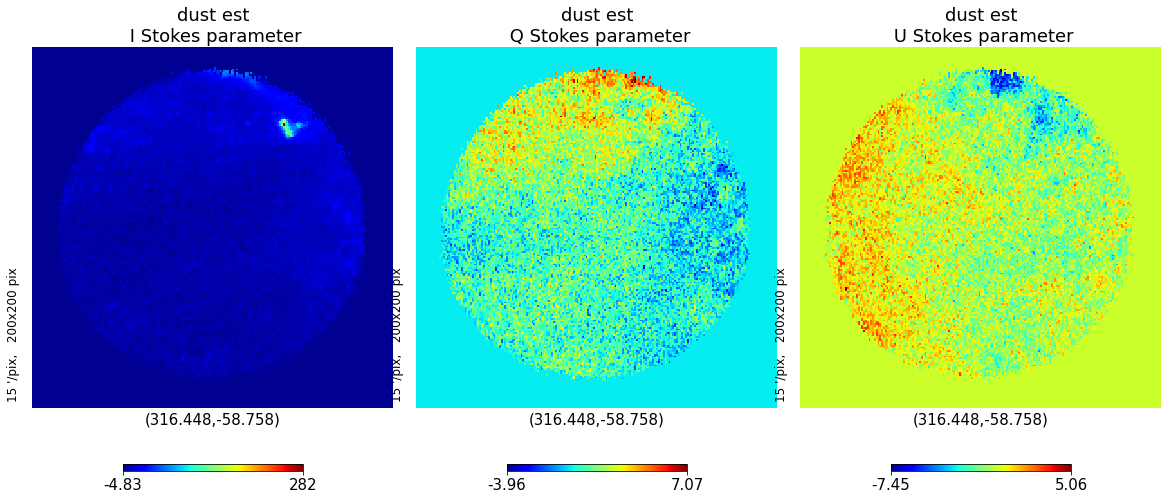

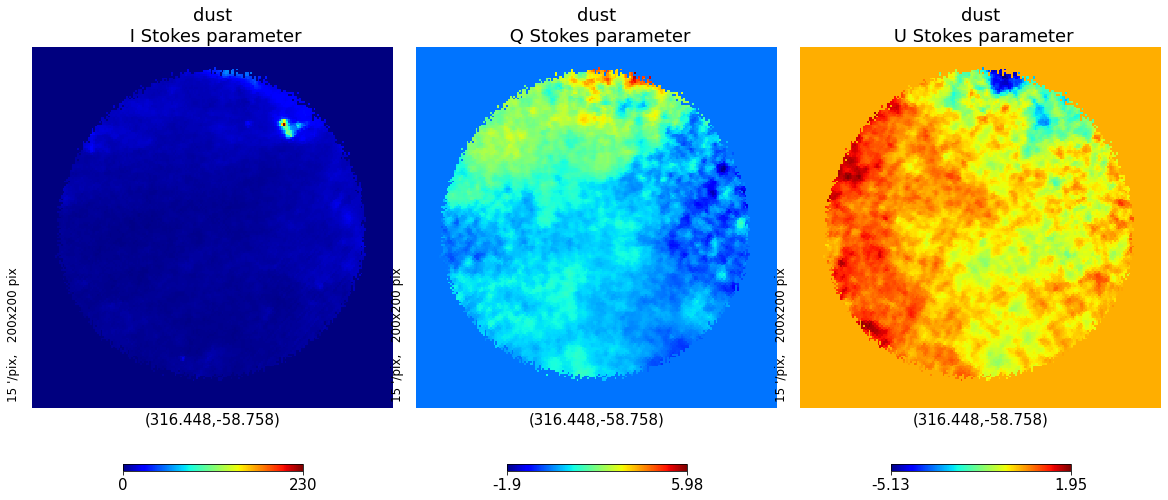

In [29]:
Plots.all_components(dust_est_fg, indf, center, 15, 'dust est')
Plots.all_components(dust_only, indf, center, 15, 'dust')

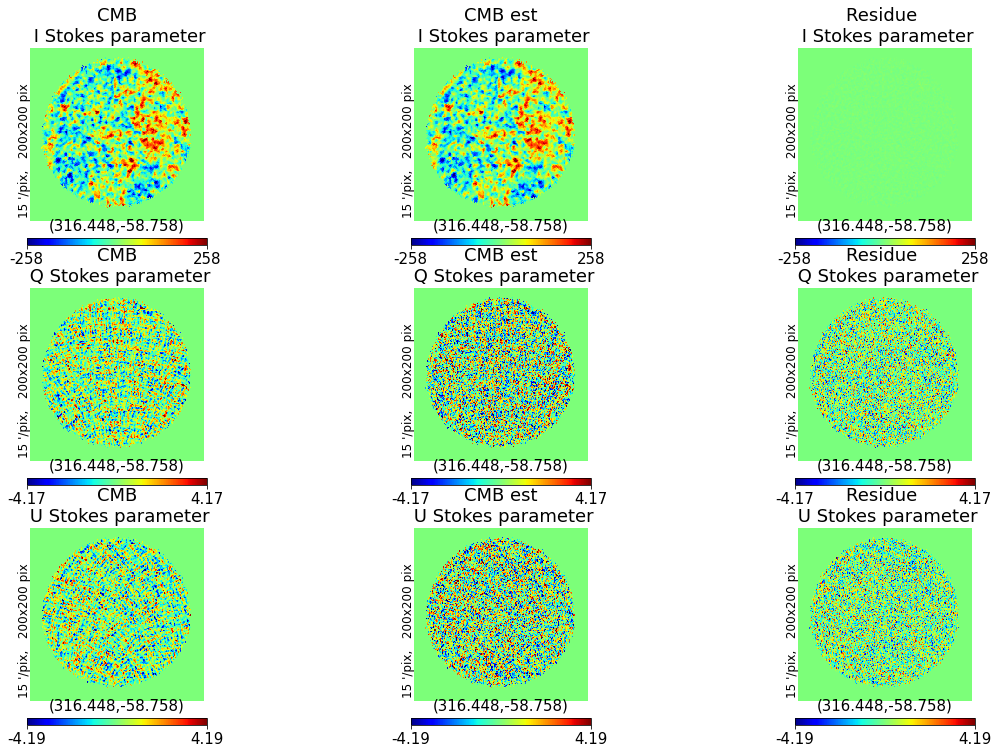

In [30]:
Plots.diff_2_maps(cmb_only, cmb_est_fg, cov150, indf, center, 15, 'CMB', 'CMB est')

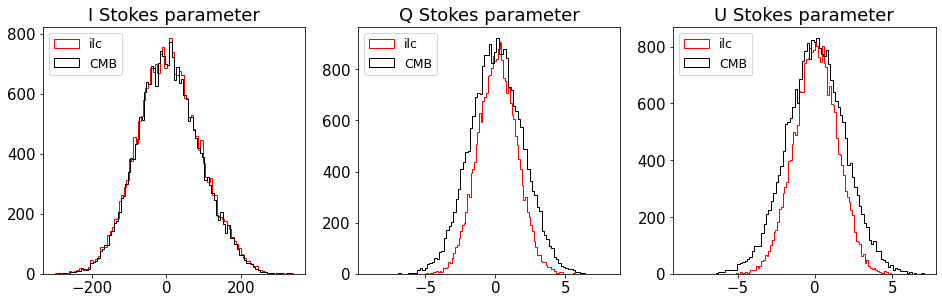

In [31]:
a1, b1, a2, b2 = Plots.diff_2_hist(cmb_only, cmb_est_fg, cov150, indf, 'ilc', 'CMB')